In [3]:
from casadi import *
import numpy as np


In [4]:
# create a very simply ode example.
# solution using direct collocation.
# F = m * x'' 
# states = x and x'
# matrix form equation - 
# d/dt (xdot) = F / m
# d/dt (x) = xdot

N = 10 # number of intermediate steps

x_ = MX.sym("x") # position
dx = MX.sym("dx") # velocity
x = vertcat(dx, x_)

F = MX.sym("F") # Force
T = MX.sym("T") # final time

m = 1
start = np.zeros(2) # start at 0,0
end = np.array([2,0]) # end at 2,0

W = dx**2 + F**2
xdot = vertcat(np.sin(F/m), dx)
hk = T/N


In [107]:
f = Function('f', [x, F], [xdot],['xk','F'],['f_k'])
W = Function('w', [x,F], [W], ['x', 'F'], ["wk"])


In [108]:
v= f(xk=[2,0], F= 1)
v['f_k']

DM([1, 2])

In [109]:
w = [] # optimization variables.
w0 = [] # initial conditions.
lbw = [] # lower bound w.
ubw = [] # upper bound 2.
J = 0 # total cost.
g = [] # constraints.
lbg = [] # lower bound constraints.
ubg = [] # upper bound constraints.

In [110]:
# Nonlinear program description.
# initial value constraint


Xk = MX.sym('X_0', 2)
Fk = MX.sym('F_0', 1)

w += [Xk, Fk]
w0 += [0, 0, 2]
lbw += [0, 0, -2.0]
ubw += [0, 0, 2.0]

for i in range(N - 1):
    Xk_1 = MX.sym(f'X_{i + 1}', 2)
    Fk_1 = MX.sym(f'F_{i + 1}', 1)
    J += 0.5 * hk * (W(x = Xk, F= Fk)['wk'] + W(x = Xk_1, F= Fk_1)['wk'])

    # Add equality constraint
    g   += [Xk_1-Xk - 0.5*hk *(f(xk=Xk, F= Fk)['f_k'] + f(xk=Xk_1, F= Fk_1)['f_k'])]
    lbg += [0, 0]
    ubg += [0, 0]
    Xk = Xk_1
    Fk = Fk_1
    w += [Xk, Fk]
    Force0 = 2 if i < (N - 2)//2 else -2
    w0 += [0, (i + 1)*2/N, Force0]
    if(i == N - 2):
        lbw += [0, 2, -2.0]
        ubw += [0, 2, 2.0]
    else:
        lbw += [-float('inf'), -float('inf'), -2.0]
        ubw += [float('inf'), float('inf'), 2.0]



w += [T]
w0 += [2]
lbw += [0.1]
ubw += [10]


prob = {'f': J + 100 * T, 'x': vertcat(*w), 'g': vertcat(*g)}
solver = nlpsol('solver', 'ipopt', prob)
sol = solver(x0=w0, lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg)
w_opt = sol['x'].full().flatten()
    

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       84
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       36

Total number of variables............................:       27
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       11
                     variables with only upper bounds:        0
Total number of equality constraints.................:       18
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [111]:
v0 = w0[0:-1:3]
pos0 = w0[1:-1:3]
F0_ = w0[2:-1:3]

In [112]:
v = w_opt[0:-1:3]
pos = w_opt[1:-1:3]
F_ = w_opt[2:-1:3]


In [113]:
import matplotlib.pyplot as plt

%matplotlib inline

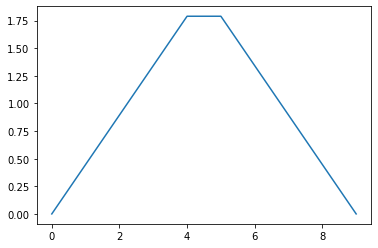

In [114]:
plt.plot(v)

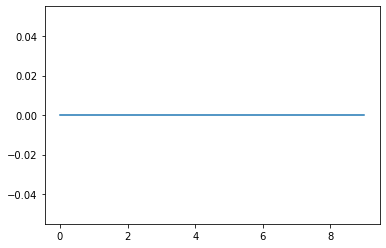

In [115]:
plt.plot(v0)

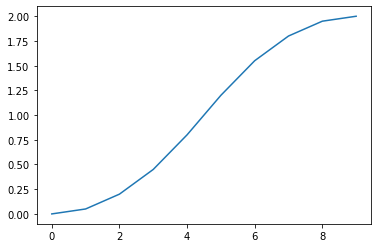

In [116]:
plt.plot(pos)

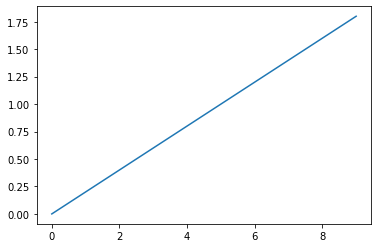

In [117]:
plt.plot(pos0)

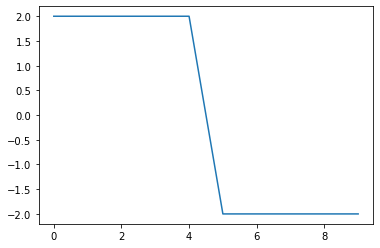

In [118]:
plt.plot(F_)

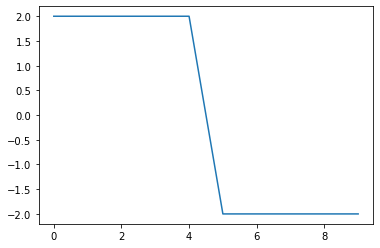

In [119]:
plt.plot(F0_)

In [120]:
sol["f"]

DM(234.34)